# AutoVI Evaluation - Stage 1
## Centralized vs Federated Model Comparison

In [42]:
import os
import sys
import json
import warnings
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import roc_curve
from scipy import stats
from tqdm.notebook import tqdm

from utils import (
    AutoVITestDataset, 
    load_model, 
    compute_anomaly_score,
    get_default_transform
)
from metrics import (
    calculate_metrics, 
    calculate_per_category_metrics,
    calculate_optimal_threshold
)

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch: 2.5.1+cu124
CUDA available: True


In [43]:
class Config:
    # Paths
    TEST_DATA_DIR = "/home/danyez87/Master AI/3rd Semester/AITDM/ClaudiuAutoVI_federated_5clients/test_data_centralized"
    CENTRALIZED_MODEL_PATH = "/home/danyez87/Master AI/3rd Semester/AITDM/ClaudiuAutoVI_federated_5clients/weights_all_data.pth"
    FEDERATED_MODEL_PATH = "/home/danyez87/Master AI/3rd Semester/AITDM/ClaudiuAutoVI_federated_5clients/global_model_round_30.pth"
    OUTPUT_DIR = "./evaluation_results"
    
    # Settings
    BATCH_SIZE = 8
    NUM_WORKERS = 4
    TARGET_SIZE = (256, 256)
    TNR_THRESHOLDS = [0.99, 0.95, 0.90]
    SAVE_FIGURES = True

os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [44]:
test_transform = get_default_transform()

test_dataset = AutoVITestDataset(
    root_dir=Config.TEST_DATA_DIR,
    transform=test_transform,
    target_size=Config.TARGET_SIZE
)

test_loader = DataLoader(
    test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=Config.NUM_WORKERS,
    pin_memory=torch.cuda.is_available()
)

stats = test_dataset.get_statistics()

summary_data = []
for cat, cat_stats in stats['categories'].items():
    summary_data.append({
        'Category': cat,
        'Good': cat_stats['good'],
        'Anomaly': cat_stats['anomaly'],
        'Total': cat_stats['good'] + cat_stats['anomaly']
    })

stats_df = pd.DataFrame(summary_data)
display(stats_df)

INFO:utils:✓ Loaded 2399 test samples from /home/danyez87/Master AI/3rd Semester/AITDM/ClaudiuAutoVI_federated_5clients/test_data_centralized


,Category,Good,Anomaly,Total
0,engine_wiring,285,322,607
1,pipe_clip,195,142,337
2,pipe_staple,188,117,305
3,tank_screw,318,95,413
4,underbody_pipes,161,184,345
5,underbody_screw,374,18,392


In [45]:
centralized_model = load_model(Config.CENTRALIZED_MODEL_PATH, device, model_type='centralized')
federated_model = load_model(Config.FEDERATED_MODEL_PATH, device, model_type='federated')

INFO:utils:Loading checkpoint from /home/danyez87/Master AI/3rd Semester/AITDM/ClaudiuAutoVI_federated_5clients/weights_all_data.pth
INFO:utils:✓ Loaded centralized model (31,043,651 parameters)
INFO:utils:Loading checkpoint from /home/danyez87/Master AI/3rd Semester/AITDM/ClaudiuAutoVI_federated_5clients/global_model_round_30.pth
INFO:utils:✓ Loaded federated model (17,263,107 parameters)


In [46]:
def evaluate_model(model, dataloader, device, model_name="Model"):
    """Evaluate model and return predictions."""
    all_labels = []
    all_scores = []
    all_categories = []
    all_defect_types = []
    all_paths = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=model_name):
            images = batch['image']
            
            for i in range(len(images)):
                score = compute_anomaly_score(model, images[i], device)
                
                all_labels.append(batch['label'][i].item())
                all_scores.append(score)
                all_categories.append(batch['category'][i])
                all_defect_types.append(batch['defect_type'][i])
                all_paths.append(batch['image_path'][i])
    
    return {
        'labels': all_labels,
        'scores': all_scores,
        'categories': all_categories,
        'defect_types': all_defect_types,
        'paths': all_paths,
        'model_name': model_name
    }

In [47]:
cent_results = evaluate_model(centralized_model, test_loader, device, "Centralized")
fed_results = evaluate_model(federated_model, test_loader, device, "Federated")

Centralized:   0%|          | 0/300 [00:00<?, ?it/s]

Federated:   0%|          | 0/300 [00:00<?, ?it/s]

In [48]:
cent_overall = calculate_metrics(
    np.array(cent_results['labels']), 
    np.array(cent_results['scores']),
    Config.TNR_THRESHOLDS
)

fed_overall = calculate_metrics(
    np.array(fed_results['labels']), 
    np.array(fed_results['scores']),
    Config.TNR_THRESHOLDS
)

cent_per_cat = calculate_per_category_metrics(
    cent_results['labels'],
    cent_results['scores'],
    cent_results['categories'],
    Config.TNR_THRESHOLDS
)

fed_per_cat = calculate_per_category_metrics(
    fed_results['labels'],
    fed_results['scores'],
    fed_results['categories'],
    Config.TNR_THRESHOLDS
)

cent_threshold, cent_f1 = calculate_optimal_threshold(
    np.array(cent_results['labels']),
    np.array(cent_results['scores']),
    method='f1'
)

fed_threshold, fed_f1 = calculate_optimal_threshold(
    np.array(fed_results['labels']),
    np.array(fed_results['scores']),
    method='f1'
)

print(f"Optimal thresholds - Centralized: {cent_threshold:.4f} (F1={cent_f1:.4f}), Federated: {fed_threshold:.4f} (F1={fed_f1:.4f})")

Optimal thresholds - Centralized: 0.0013 (F1=0.5973), Federated: 0.0846 (F1=0.5704)


---
## Results
### Table 1: Overall Performance

In [49]:
comparison_data = {
    'Metric': ['AUROC', 'Average Precision', 'TPR @ TNR=99%', 'TPR @ TNR=95%', 'TPR @ TNR=90%'],
    'Centralized': [
        cent_overall['AUROC'],
        cent_overall['AP'],
        cent_overall['TPR@TNR99'],
        cent_overall['TPR@TNR95'],
        cent_overall['TPR@TNR90']
    ],
    'Federated': [
        fed_overall['AUROC'],
        fed_overall['AP'],
        fed_overall['TPR@TNR99'],
        fed_overall['TPR@TNR95'],
        fed_overall['TPR@TNR90']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Delta'] = comparison_df['Centralized'] - comparison_df['Federated']

styled_comparison = comparison_df.style.format({
    'Centralized': '{:.4f}',
    'Federated': '{:.4f}',
    'Delta': '{:+.4f}'
}).background_gradient(subset=['Delta'], cmap='RdYlGn', vmin=-0.15, vmax=0.15)

display(styled_comparison)

,Metric,Centralized,Federated,Delta
0,AUROC,0.6155,0.6670,-0.0515
1,Average Precision,0.4384,0.5266,-0.0883
2,TPR @ TNR=99%,0.0000,0.0319,-0.0319
3,TPR @ TNR=95%,0.1162,0.1264,-0.0103
4,TPR @ TNR=90%,0.1982,0.2608,-0.0626


### Table 2: Per-Category Performance

In [50]:
cat_data = []
for cat in sorted(cent_per_cat.keys()):
    cat_data.append({
        'Category': cat,
        'Cent AUROC': cent_per_cat[cat]['AUROC'],
        'Fed AUROC': fed_per_cat[cat]['AUROC'],
        'Delta AUROC': cent_per_cat[cat]['AUROC'] - fed_per_cat[cat]['AUROC'],
        'Cent AP': cent_per_cat[cat]['AP'],
        'Fed AP': fed_per_cat[cat]['AP'],
        'Samples': cent_per_cat[cat]['n_samples'],
        'Anomalies': cent_per_cat[cat]['n_anomalies']
    })

cat_df = pd.DataFrame(cat_data)

styled_cat = cat_df.style.format({
    'Cent AUROC': '{:.4f}',
    'Fed AUROC': '{:.4f}',
    'Delta AUROC': '{:+.4f}',
    'Cent AP': '{:.4f}',
    'Fed AP': '{:.4f}'
}).background_gradient(subset=['Delta AUROC'], cmap='RdYlGn', vmin=-0.2, vmax=0.2)

display(styled_cat)

,Category,Cent AUROC,Fed AUROC,Delta AUROC,Cent AP,Fed AP,Samples,Anomalies
0,engine_wiring,0.6611,0.4510,+0.2101,0.7115,0.5175,607,322
1,pipe_clip,0.4603,0.5520,-0.0917,0.3917,0.4667,337,142
2,pipe_staple,0.3026,0.3289,-0.0263,0.3073,0.2856,305,117
3,tank_screw,0.4551,0.4387,+0.0164,0.2185,0.2161,413,95
4,underbody_pipes,0.5109,0.8602,-0.3493,0.4947,0.8589,345,184
5,underbody_screw,0.9346,0.0778,+0.8568,0.8479,0.0259,392,18


### Table 3: TPR at Fixed TNR Thresholds

In [51]:
tpr_tnr_data = []
categories_sorted = sorted(cent_per_cat.keys())

for cat in categories_sorted:
    for tnr in [99, 95, 90]:
        metric_key = f'TPR@TNR{tnr}'
        tpr_tnr_data.append({
            'Category': cat,
            'TNR (%)': tnr,
            'Centralized TPR (%)': cent_per_cat[cat][metric_key] * 100,
            'Federated TPR (%)': fed_per_cat[cat][metric_key] * 100,
            'Delta TPR (%)': (cent_per_cat[cat][metric_key] - fed_per_cat[cat][metric_key]) * 100
        })

tpr_tnr_df = pd.DataFrame(tpr_tnr_data)

# Combined wide-format table
combined_tpr_data = []
for cat in categories_sorted:
    combined_tpr_data.append({
        'Category': cat,
        'Cent@99': cent_per_cat[cat]['TPR@TNR99'] * 100,
        'Fed@99': fed_per_cat[cat]['TPR@TNR99'] * 100,
        'Cent@95': cent_per_cat[cat]['TPR@TNR95'] * 100,
        'Fed@95': fed_per_cat[cat]['TPR@TNR95'] * 100,
        'Cent@90': cent_per_cat[cat]['TPR@TNR90'] * 100,
        'Fed@90': fed_per_cat[cat]['TPR@TNR90'] * 100,
    })

combined_tpr_df = pd.DataFrame(combined_tpr_data)

styled_tpr = combined_tpr_df.style.format({
    'Cent@99': '{:.1f}%', 'Fed@99': '{:.1f}%',
    'Cent@95': '{:.1f}%', 'Fed@95': '{:.1f}%',
    'Cent@90': '{:.1f}%', 'Fed@90': '{:.1f}%',
})

display(styled_tpr)

# Detailed print
print("\nDetailed TPR@TNR by Category:")
print("-" * 70)
for cat in categories_sorted:
    print(f"\n{cat}:")
    print(f"  TNR=99%: Cent={cent_per_cat[cat]['TPR@TNR99']*100:5.1f}%  Fed={fed_per_cat[cat]['TPR@TNR99']*100:5.1f}%")
    print(f"  TNR=95%: Cent={cent_per_cat[cat]['TPR@TNR95']*100:5.1f}%  Fed={fed_per_cat[cat]['TPR@TNR95']*100:5.1f}%")
    print(f"  TNR=90%: Cent={cent_per_cat[cat]['TPR@TNR90']*100:5.1f}%  Fed={fed_per_cat[cat]['TPR@TNR90']*100:5.1f}%")

,Category,Cent@99,Fed@99,Cent@95,Fed@95,Cent@90,Fed@90
0,engine_wiring,11.2%,1.2%,23.6%,6.5%,25.8%,10.9%
1,pipe_clip,0.0%,2.1%,3.5%,3.5%,6.3%,11.3%
2,pipe_staple,0.0%,0.0%,3.4%,0.0%,6.0%,0.0%
3,tank_screw,2.1%,2.1%,3.2%,4.2%,6.3%,7.4%
4,underbody_pipes,0.0%,17.4%,0.0%,35.3%,0.0%,53.8%
5,underbody_screw,83.3%,0.0%,83.3%,0.0%,94.4%,0.0%



Detailed TPR@TNR by Category:
----------------------------------------------------------------------

engine_wiring:
  TNR=99%: Cent= 11.2%  Fed=  1.2%
  TNR=95%: Cent= 23.6%  Fed=  6.5%
  TNR=90%: Cent= 25.8%  Fed= 10.9%

pipe_clip:
  TNR=99%: Cent=  0.0%  Fed=  2.1%
  TNR=95%: Cent=  3.5%  Fed=  3.5%
  TNR=90%: Cent=  6.3%  Fed= 11.3%

pipe_staple:
  TNR=99%: Cent=  0.0%  Fed=  0.0%
  TNR=95%: Cent=  3.4%  Fed=  0.0%
  TNR=90%: Cent=  6.0%  Fed=  0.0%

tank_screw:
  TNR=99%: Cent=  2.1%  Fed=  2.1%
  TNR=95%: Cent=  3.2%  Fed=  4.2%
  TNR=90%: Cent=  6.3%  Fed=  7.4%

underbody_pipes:
  TNR=99%: Cent=  0.0%  Fed= 17.4%
  TNR=95%: Cent=  0.0%  Fed= 35.3%
  TNR=90%: Cent=  0.0%  Fed= 53.8%

underbody_screw:
  TNR=99%: Cent= 83.3%  Fed=  0.0%
  TNR=95%: Cent= 83.3%  Fed=  0.0%
  TNR=90%: Cent= 94.4%  Fed=  0.0%


## Visualizations

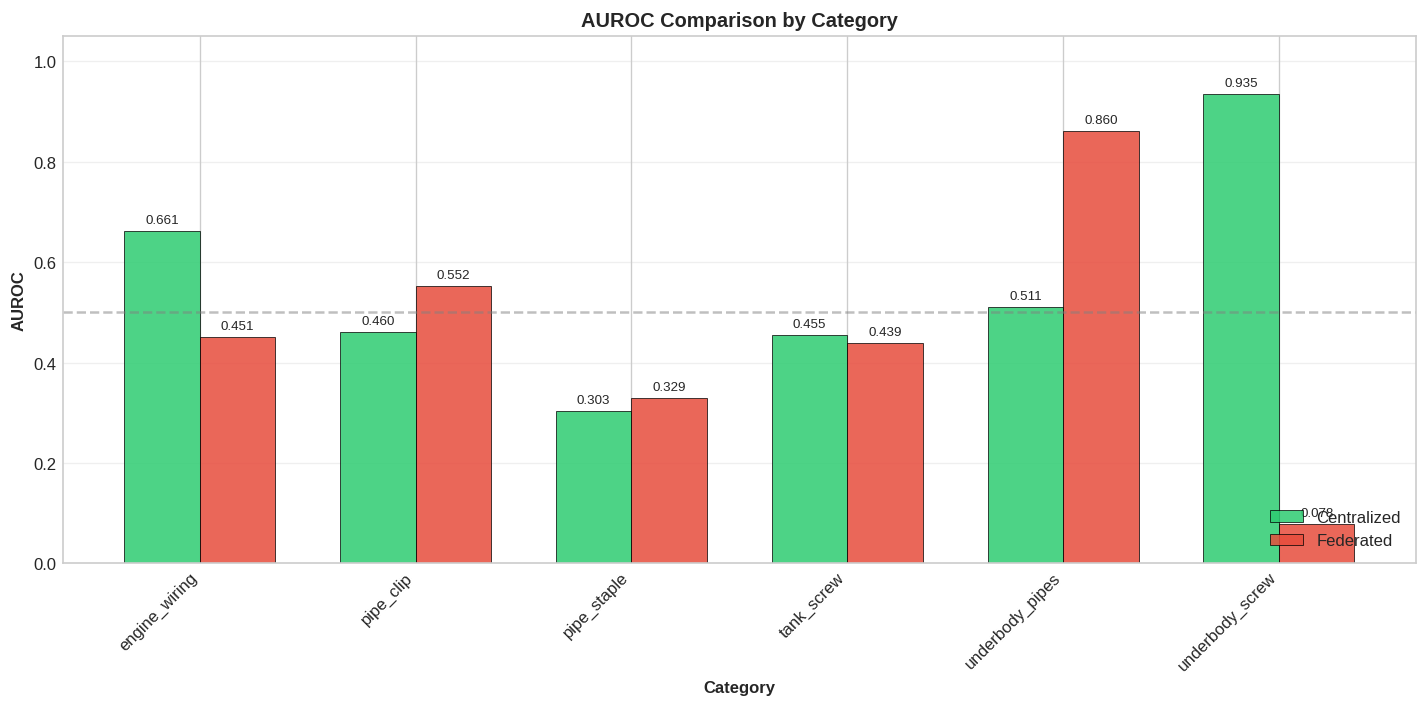

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(categories_sorted))
width = 0.35

cent_aurocs = [cent_per_cat[cat]['AUROC'] for cat in categories_sorted]
fed_aurocs = [fed_per_cat[cat]['AUROC'] for cat in categories_sorted]

bars1 = ax.bar(x - width/2, cent_aurocs, width, label='Centralized', color='#2ecc71', alpha=0.85, edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x + width/2, fed_aurocs, width, label='Federated', color='#e74c3c', alpha=0.85, edgecolor='black', linewidth=0.5)

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Category', fontweight='bold')
ax.set_ylabel('AUROC', fontweight='bold')
ax.set_title('AUROC Comparison by Category', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories_sorted, rotation=45, ha='right')
ax.legend(loc='lower right')
ax.set_ylim([0, 1.05])
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
if Config.SAVE_FIGURES:
    plt.savefig(f"{Config.OUTPUT_DIR}/fig1_auroc_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

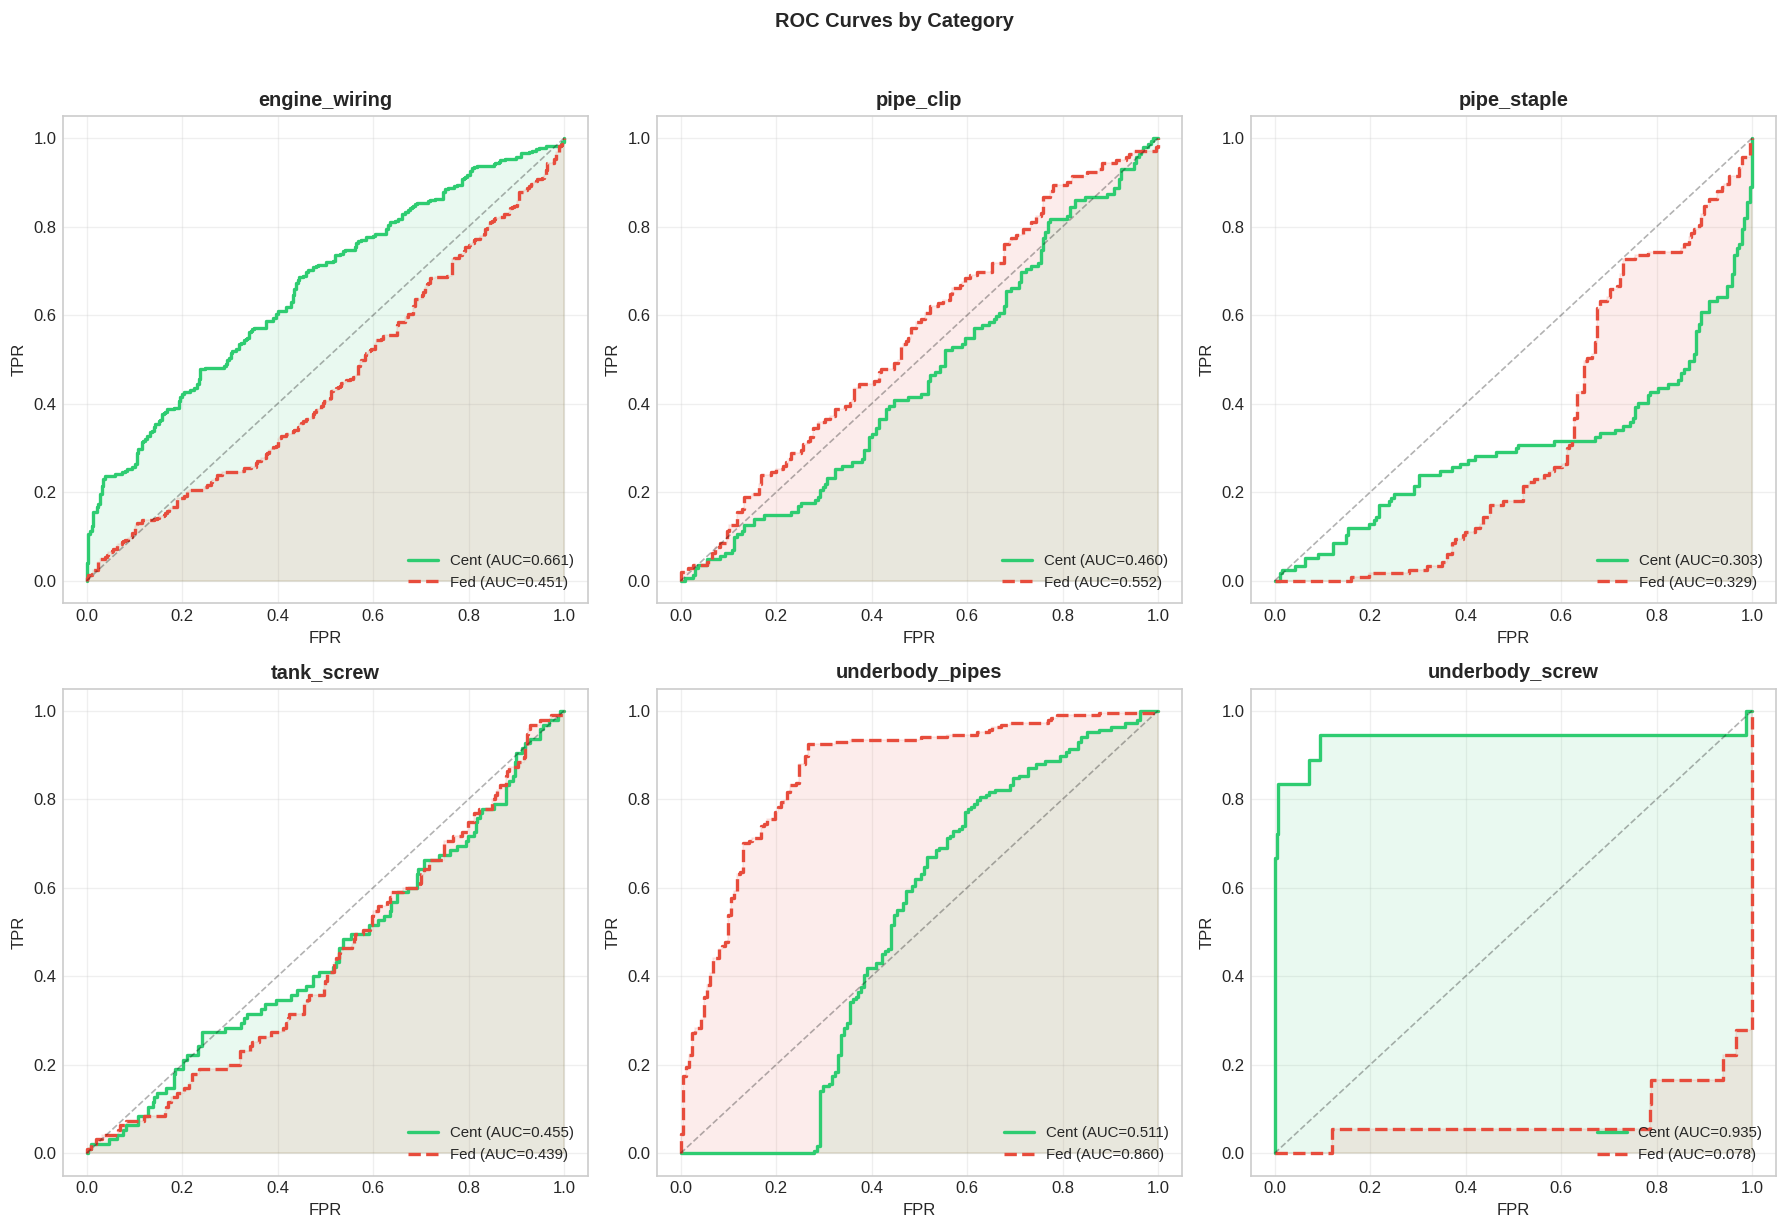

In [53]:
n_categories = len(categories_sorted)
n_cols = 3
n_rows = (n_categories + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_categories > 1 else [axes]

for idx, cat in enumerate(categories_sorted):
    ax = axes[idx]
    
    cat_indices = [i for i, c in enumerate(cent_results['categories']) if c == cat]
    cent_labels = np.array([cent_results['labels'][i] for i in cat_indices])
    cent_scores = np.array([cent_results['scores'][i] for i in cat_indices])
    
    cat_indices_fed = [i for i, c in enumerate(fed_results['categories']) if c == cat]
    fed_labels = np.array([fed_results['labels'][i] for i in cat_indices_fed])
    fed_scores = np.array([fed_results['scores'][i] for i in cat_indices_fed])
    
    if len(np.unique(cent_labels)) == 2:
        fpr_cent, tpr_cent, _ = roc_curve(cent_labels, cent_scores)
        ax.plot(fpr_cent, tpr_cent, color='#2ecc71', label=f'Cent (AUC={cent_per_cat[cat]["AUROC"]:.3f})', linewidth=2)
        ax.fill_between(fpr_cent, tpr_cent, alpha=0.1, color='#2ecc71')
    
    if len(np.unique(fed_labels)) == 2:
        fpr_fed, tpr_fed, _ = roc_curve(fed_labels, fed_scores)
        ax.plot(fpr_fed, tpr_fed, color='#e74c3c', label=f'Fed (AUC={fed_per_cat[cat]["AUROC"]:.3f})', linewidth=2, linestyle='--')
        ax.fill_between(fpr_fed, tpr_fed, alpha=0.1, color='#e74c3c')
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title(cat, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(alpha=0.3)

for idx in range(len(categories_sorted), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('ROC Curves by Category', fontweight='bold', y=1.02)
plt.tight_layout()
if Config.SAVE_FIGURES:
    plt.savefig(f"{Config.OUTPUT_DIR}/fig2_roc_curves.png", dpi=300, bbox_inches='tight')
plt.show()

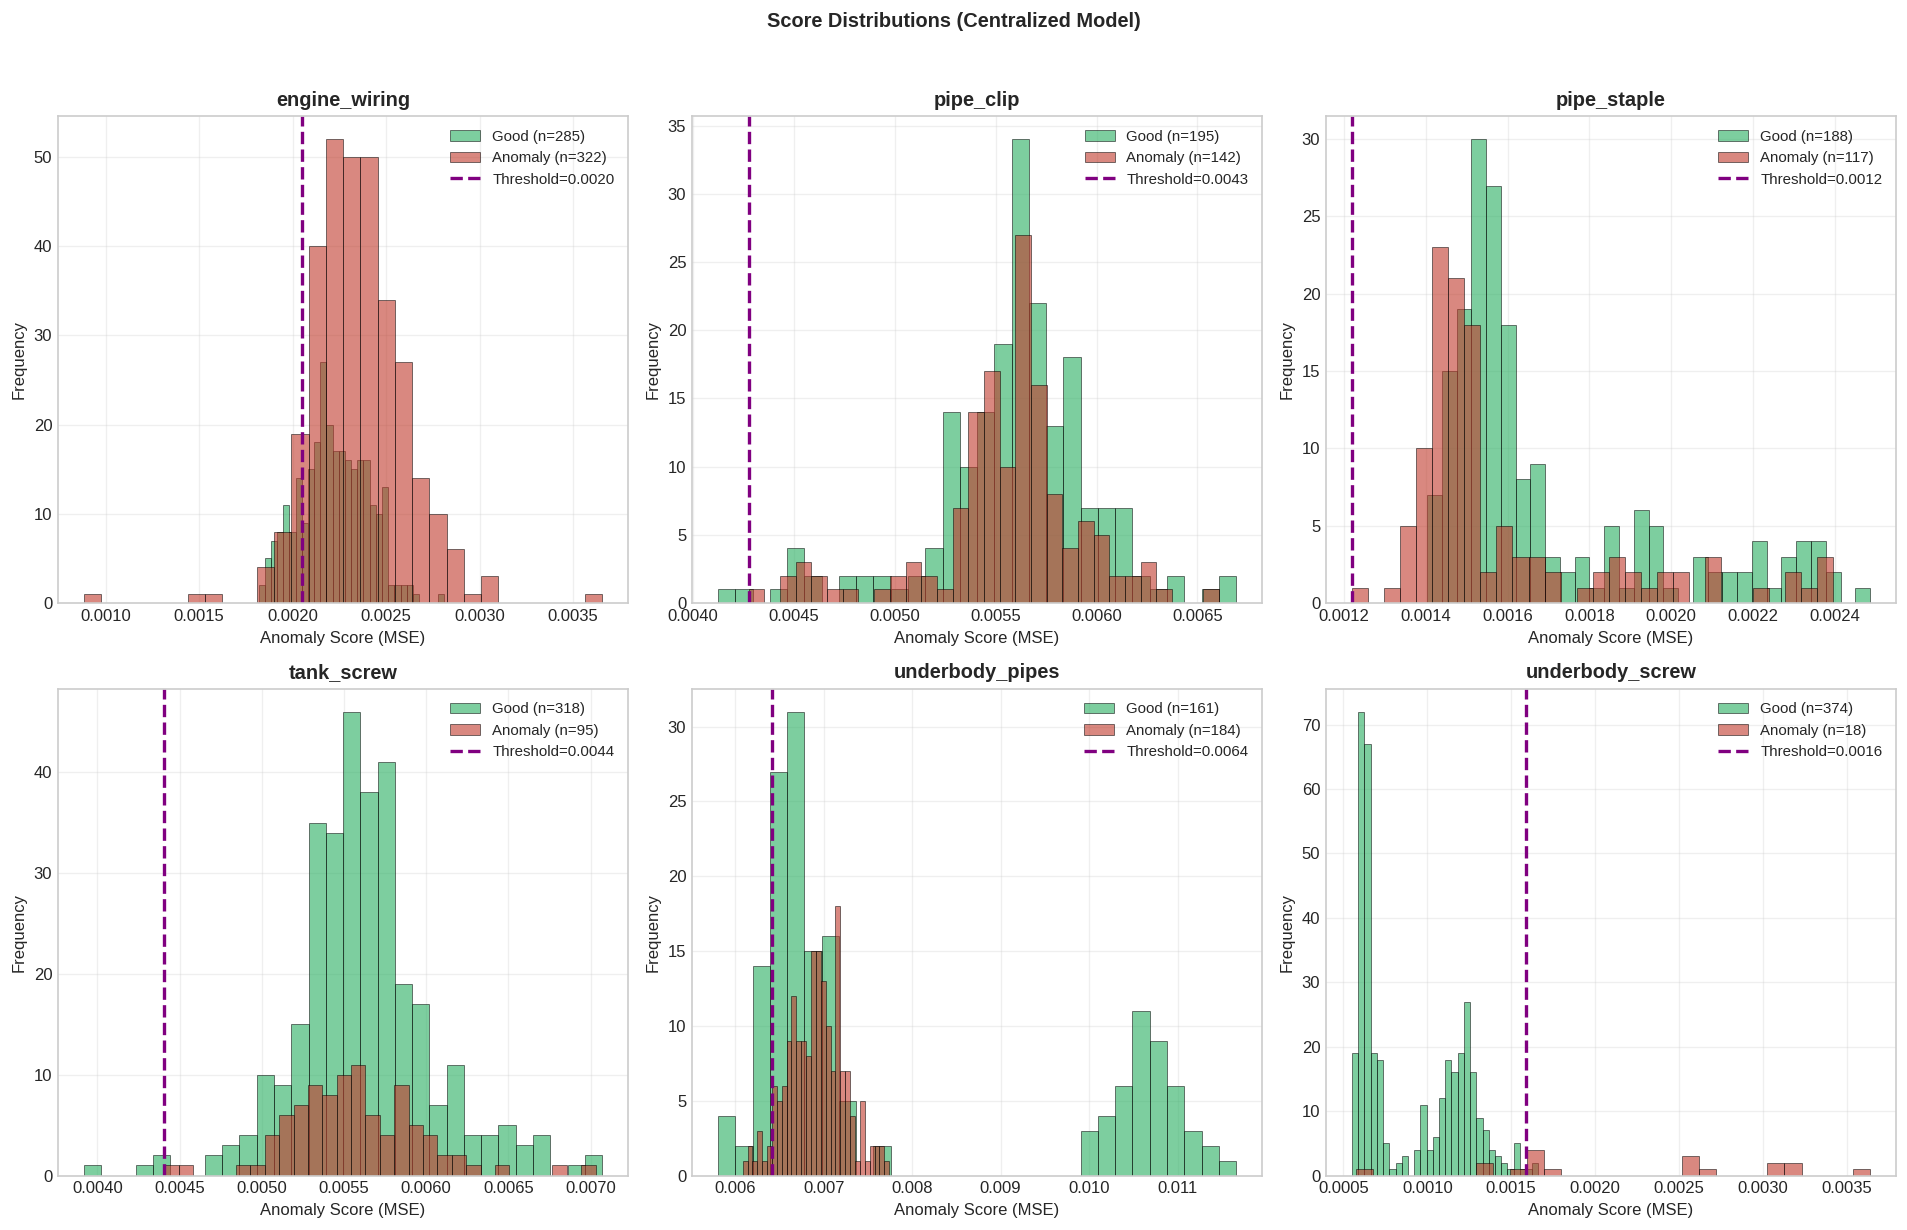

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, cat in enumerate(categories_sorted):
    ax = axes[idx]
    
    cat_indices = [i for i, c in enumerate(cent_results['categories']) if c == cat]
    cat_labels = np.array([cent_results['labels'][i] for i in cat_indices])
    cat_scores = np.array([cent_results['scores'][i] for i in cat_indices])
    
    good_scores = cat_scores[cat_labels == 0]
    anomaly_scores = cat_scores[cat_labels == 1]
    
    if len(good_scores) > 0:
        ax.hist(good_scores, bins=30, alpha=0.6, label=f'Good (n={len(good_scores)})', color='#27ae60', edgecolor='black', linewidth=0.5)
    if len(anomaly_scores) > 0:
        ax.hist(anomaly_scores, bins=30, alpha=0.6, label=f'Anomaly (n={len(anomaly_scores)})', color='#c0392b', edgecolor='black', linewidth=0.5)
    
    if len(good_scores) > 0 and len(anomaly_scores) > 0:
        opt_thresh, _ = calculate_optimal_threshold(cat_labels, cat_scores, 'f1')
        ax.axvline(x=opt_thresh, color='purple', linestyle='--', linewidth=2, label=f'Threshold={opt_thresh:.4f}')
    
    ax.set_xlabel('Anomaly Score (MSE)')
    ax.set_ylabel('Frequency')
    ax.set_title(cat, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

for idx in range(len(categories_sorted), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Score Distributions (Centralized Model)', fontweight='bold', y=1.02)
plt.tight_layout()
if Config.SAVE_FIGURES:
    plt.savefig(f"{Config.OUTPUT_DIR}/fig3_score_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

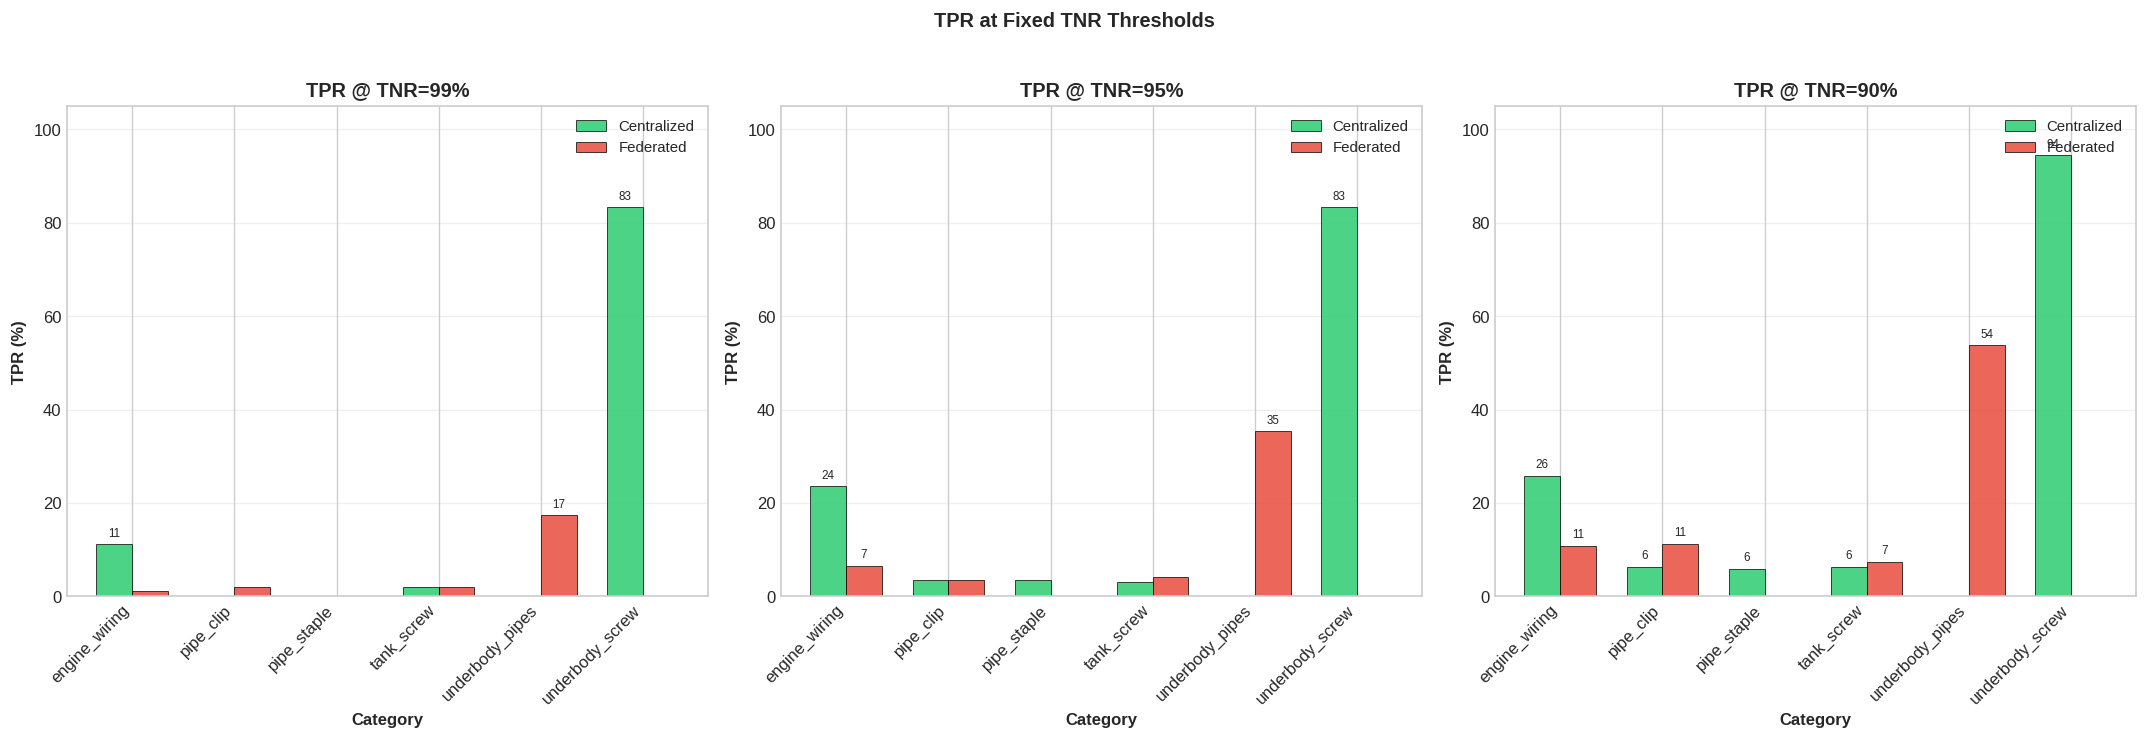

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

tnr_levels = [99, 95, 90]
x = np.arange(len(categories_sorted))
width = 0.35

for idx, tnr in enumerate(tnr_levels):
    ax = axes[idx]
    metric_key = f'TPR@TNR{tnr}'
    
    cent_tpr = [cent_per_cat[cat][metric_key] * 100 for cat in categories_sorted]
    fed_tpr = [fed_per_cat[cat][metric_key] * 100 for cat in categories_sorted]
    
    bars1 = ax.bar(x - width/2, cent_tpr, width, label='Centralized', color='#2ecc71', alpha=0.85, edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x + width/2, fed_tpr, width, label='Federated', color='#e74c3c', alpha=0.85, edgecolor='black', linewidth=0.5)
    
    for bar in bars1:
        height = bar.get_height()
        if height > 5:
            ax.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=7)
    
    for bar in bars2:
        height = bar.get_height()
        if height > 5:
            ax.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=7)
    
    ax.set_xlabel('Category', fontweight='bold')
    ax.set_ylabel('TPR (%)', fontweight='bold')
    ax.set_title(f'TPR @ TNR={tnr}%', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories_sorted, rotation=45, ha='right')
    ax.legend(loc='upper right', fontsize=9)
    ax.set_ylim([0, 105])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('TPR at Fixed TNR Thresholds', fontweight='bold', y=1.02)
plt.tight_layout()
if Config.SAVE_FIGURES:
    plt.savefig(f"{Config.OUTPUT_DIR}/fig4_tpr_at_tnr.png", dpi=300, bbox_inches='tight')
plt.show()

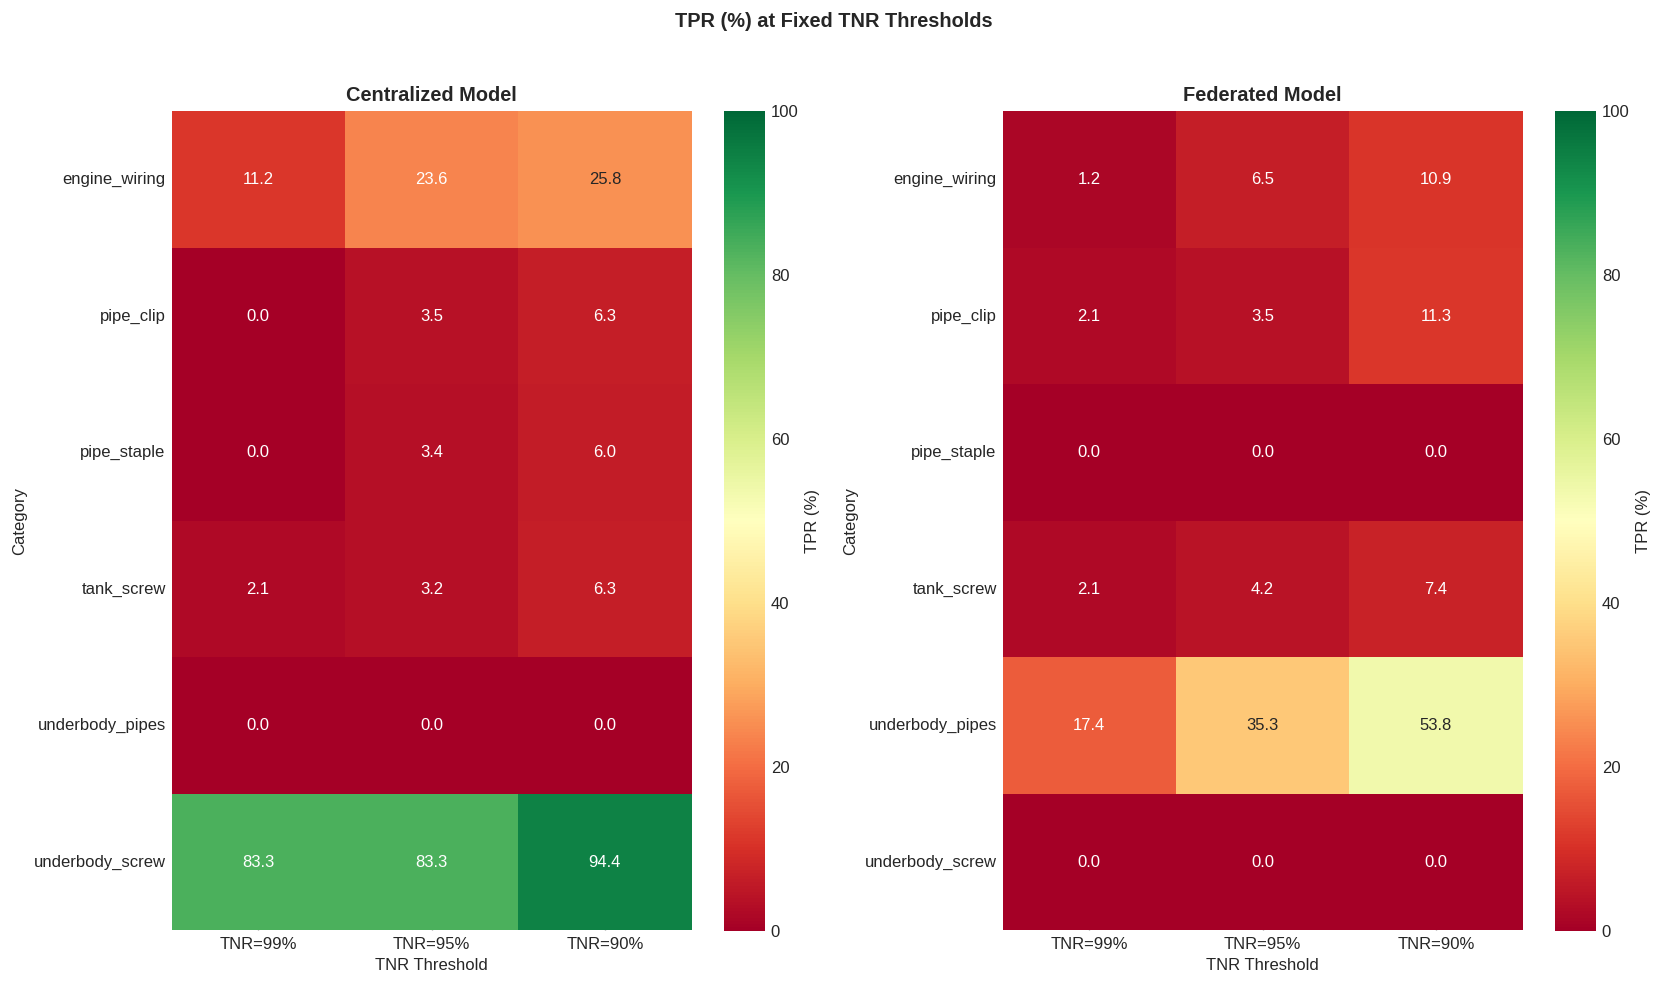

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

tnr_labels = ['TNR=99%', 'TNR=95%', 'TNR=90%']

cent_tpr_matrix = np.array([
    [cent_per_cat[cat]['TPR@TNR99'] * 100, cent_per_cat[cat]['TPR@TNR95'] * 100, cent_per_cat[cat]['TPR@TNR90'] * 100]
    for cat in categories_sorted
])

fed_tpr_matrix = np.array([
    [fed_per_cat[cat]['TPR@TNR99'] * 100, fed_per_cat[cat]['TPR@TNR95'] * 100, fed_per_cat[cat]['TPR@TNR90'] * 100]
    for cat in categories_sorted
])

sns.heatmap(cent_tpr_matrix, annot=True, fmt='.1f', cmap='RdYlGn',
            xticklabels=tnr_labels, yticklabels=categories_sorted,
            ax=axes[0], vmin=0, vmax=100, cbar_kws={'label': 'TPR (%)'})
axes[0].set_title('Centralized Model', fontweight='bold')
axes[0].set_xlabel('TNR Threshold')
axes[0].set_ylabel('Category')

sns.heatmap(fed_tpr_matrix, annot=True, fmt='.1f', cmap='RdYlGn',
            xticklabels=tnr_labels, yticklabels=categories_sorted,
            ax=axes[1], vmin=0, vmax=100, cbar_kws={'label': 'TPR (%)'})
axes[1].set_title('Federated Model', fontweight='bold')
axes[1].set_xlabel('TNR Threshold')
axes[1].set_ylabel('Category')

plt.suptitle('TPR (%) at Fixed TNR Thresholds', fontweight='bold', y=1.02)
plt.tight_layout()
if Config.SAVE_FIGURES:
    plt.savefig(f"{Config.OUTPUT_DIR}/fig5_tpr_tnr_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

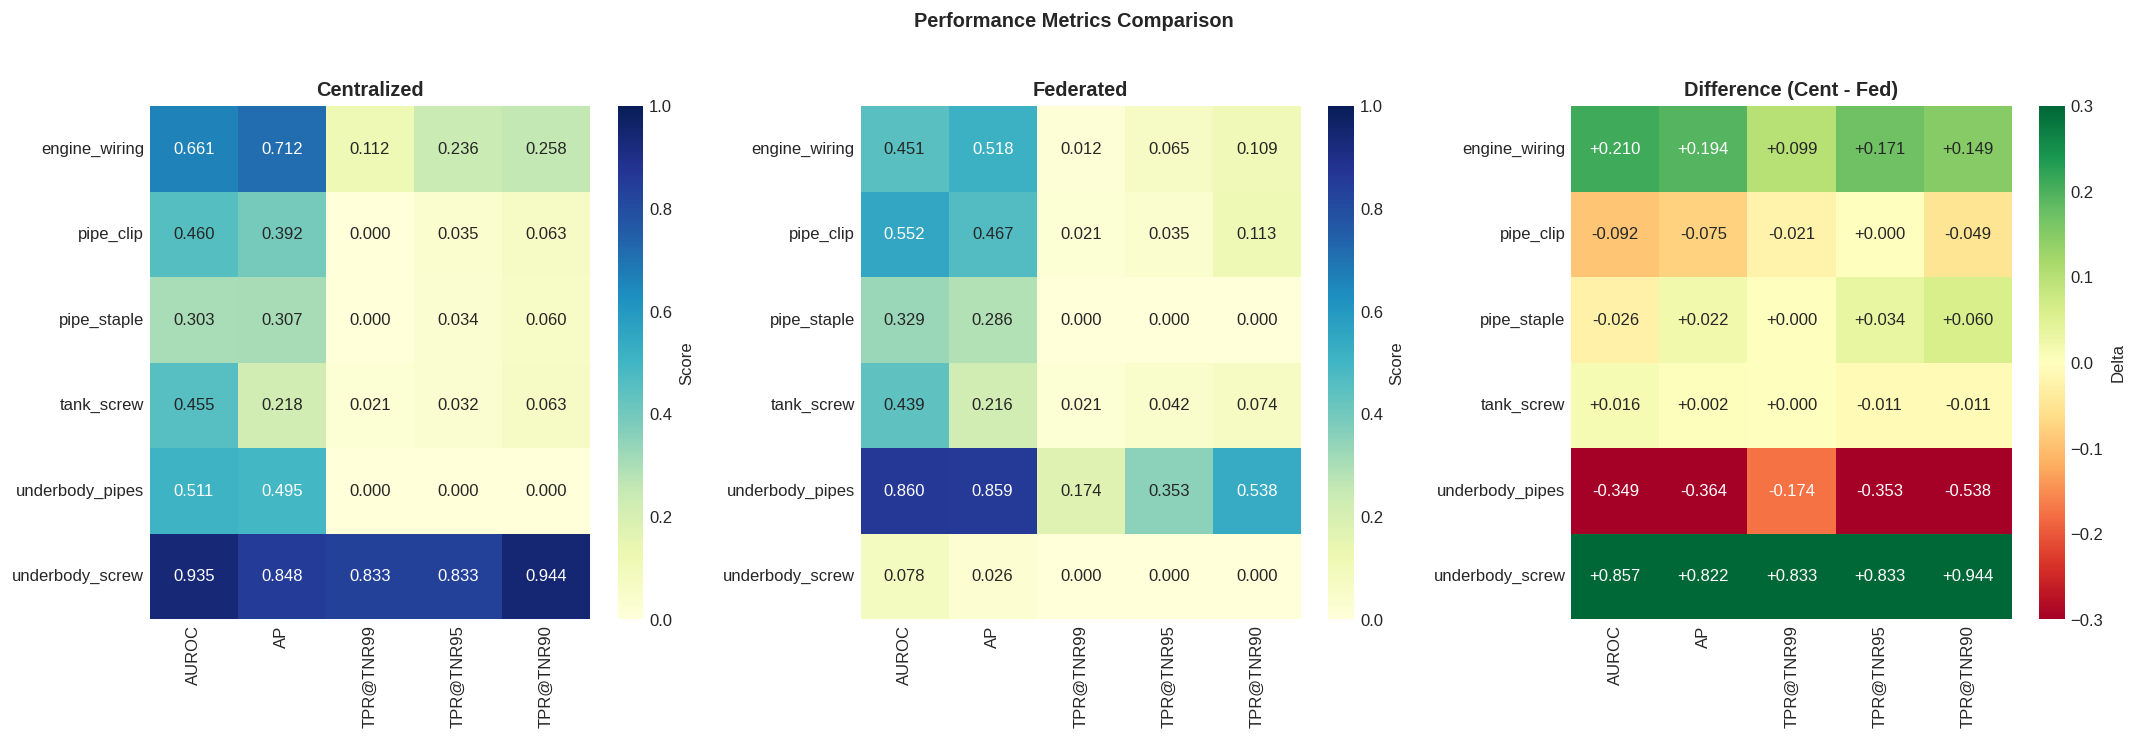

In [57]:
metrics_for_heatmap = ['AUROC', 'AP', 'TPR@TNR99', 'TPR@TNR95', 'TPR@TNR90']

cent_matrix = np.array([[cent_per_cat[cat][m] for m in metrics_for_heatmap] for cat in categories_sorted])
fed_matrix = np.array([[fed_per_cat[cat][m] for m in metrics_for_heatmap] for cat in categories_sorted])
diff_matrix = cent_matrix - fed_matrix

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(cent_matrix, annot=True, fmt='.3f', cmap='YlGnBu', 
            xticklabels=metrics_for_heatmap, yticklabels=categories_sorted,
            ax=axes[0], vmin=0, vmax=1, cbar_kws={'label': 'Score'})
axes[0].set_title('Centralized', fontweight='bold')

sns.heatmap(fed_matrix, annot=True, fmt='.3f', cmap='YlGnBu', 
            xticklabels=metrics_for_heatmap, yticklabels=categories_sorted,
            ax=axes[1], vmin=0, vmax=1, cbar_kws={'label': 'Score'})
axes[1].set_title('Federated', fontweight='bold')

sns.heatmap(diff_matrix, annot=True, fmt='+.3f', cmap='RdYlGn', 
            xticklabels=metrics_for_heatmap, yticklabels=categories_sorted,
            ax=axes[2], center=0, vmin=-0.3, vmax=0.3, cbar_kws={'label': 'Delta'})
axes[2].set_title('Difference (Cent - Fed)', fontweight='bold')

plt.suptitle('Performance Metrics Comparison', fontweight='bold', y=1.02)
plt.tight_layout()
if Config.SAVE_FIGURES:
    plt.savefig(f"{Config.OUTPUT_DIR}/fig6_metrics_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

---
## Analysis

In [58]:
print("=" * 70)
print("ANALYSIS SUMMARY")
print("=" * 70)

# Performance gaps
auroc_diff = {cat: cent_per_cat[cat]['AUROC'] - fed_per_cat[cat]['AUROC'] for cat in cent_per_cat.keys()}
max_gap_cat = max(auroc_diff, key=auroc_diff.get)
min_gap_cat = min(auroc_diff, key=auroc_diff.get)

print("\n1. Performance Gaps (Centralized - Federated):")
print(f"   Largest positive: {max_gap_cat} (Delta = {auroc_diff[max_gap_cat]:+.4f})")
print(f"   Largest negative: {min_gap_cat} (Delta = {auroc_diff[min_gap_cat]:+.4f})")
print(f"   Mean difference: {np.mean(list(auroc_diff.values())):+.4f}")

# Category difficulty
cent_aurocs_dict = {cat: cent_per_cat[cat]['AUROC'] for cat in cent_per_cat.keys()}
easiest = max(cent_aurocs_dict, key=cent_aurocs_dict.get)
hardest = min(cent_aurocs_dict, key=cent_aurocs_dict.get)

print("\n2. Category Difficulty (Centralized AUROC):")
print(f"   Easiest: {easiest} (AUROC = {cent_aurocs_dict[easiest]:.4f})")
print(f"   Hardest: {hardest} (AUROC = {cent_aurocs_dict[hardest]:.4f})")

# TPR@TNR analysis
print("\n3. TPR@TNR Analysis:")
print(f"   Mean TPR@TNR99 - Centralized: {cent_tpr_matrix[:,0].mean():.1f}%")
print(f"   Mean TPR@TNR99 - Federated: {fed_tpr_matrix[:,0].mean():.1f}%")
print(f"   Mean TPR@TNR95 - Centralized: {cent_tpr_matrix[:,1].mean():.1f}%")
print(f"   Mean TPR@TNR95 - Federated: {fed_tpr_matrix[:,1].mean():.1f}%")

# Categories needing improvement
low_perf_cats = [cat for cat, auroc in cent_aurocs_dict.items() if auroc < 0.7]
print("\n4. Categories Needing Improvement (AUROC < 0.7):")
if low_perf_cats:
    for cat in low_perf_cats:
        print(f"   {cat}: AUROC={cent_aurocs_dict[cat]:.4f}, TPR@TNR99={cent_per_cat[cat]['TPR@TNR99']*100:.1f}%")
else:
    print("   All categories above 0.7 AUROC")

# Trust dimensions
print("\n5. Trust Dimensions for Stage 2:")
print(f"   - Fairness: AUROC std = {np.std(list(cent_aurocs_dict.values())):.4f}")
low_tpr_cats = [cat for cat in cent_per_cat if cent_per_cat[cat]['TPR@TNR99'] < 0.2]
print(f"   - Robustness: {len(low_tpr_cats)} categories with TPR@TNR99 < 20%")
significant_drops = [cat for cat, diff in auroc_diff.items() if diff > 0.05]
print(f"   - Non-IID impact: {len(significant_drops)} categories with >5% centralized advantage")

print("\n" + "=" * 70)

ANALYSIS SUMMARY

1. Performance Gaps (Centralized - Federated):
   Largest positive: underbody_screw (Delta = +0.8568)
   Largest negative: underbody_pipes (Delta = -0.3493)
   Mean difference: +0.1027

2. Category Difficulty (Centralized AUROC):
   Easiest: underbody_screw (AUROC = 0.9346)
   Hardest: pipe_staple (AUROC = 0.3026)

3. TPR@TNR Analysis:
   Mean TPR@TNR99 - Centralized: 16.1%
   Mean TPR@TNR99 - Federated: 3.8%
   Mean TPR@TNR95 - Centralized: 19.5%
   Mean TPR@TNR95 - Federated: 8.3%

4. Categories Needing Improvement (AUROC < 0.7):
   engine_wiring: AUROC=0.6611, TPR@TNR99=11.2%
   pipe_clip: AUROC=0.4603, TPR@TNR99=0.0%
   pipe_staple: AUROC=0.3026, TPR@TNR99=0.0%
   tank_screw: AUROC=0.4551, TPR@TNR99=2.1%
   underbody_pipes: AUROC=0.5109, TPR@TNR99=0.0%

5. Trust Dimensions for Stage 2:
   - Fairness: AUROC std = 0.2000
   - Robustness: 5 categories with TPR@TNR99 < 20%
   - Non-IID impact: 2 categories with >5% centralized advantage



In [59]:
comparison_df.to_csv(f'{Config.OUTPUT_DIR}/table1_overall_comparison.csv', index=False)
cat_df.to_csv(f'{Config.OUTPUT_DIR}/table2_per_category.csv', index=False)
combined_tpr_df.to_csv(f'{Config.OUTPUT_DIR}/table3_tpr_at_tnr.csv', index=False)
tpr_tnr_df.to_csv(f'{Config.OUTPUT_DIR}/tpr_tnr_detailed.csv', index=False)

detailed_results = {
    'timestamp': datetime.now().isoformat(),
    'overall_metrics': {
        'centralized': cent_overall,
        'federated': fed_overall
    },
    'per_category_metrics': {
        'centralized': cent_per_cat,
        'federated': fed_per_cat
    },
    'optimal_thresholds': {
        'centralized': {'threshold': cent_threshold, 'f1': cent_f1},
        'federated': {'threshold': fed_threshold, 'f1': fed_f1}
    },
    'tpr_at_tnr_summary': {
        'centralized': {
            'mean_tpr@tnr99': float(cent_tpr_matrix[:,0].mean()),
            'mean_tpr@tnr95': float(cent_tpr_matrix[:,1].mean()),
            'mean_tpr@tnr90': float(cent_tpr_matrix[:,2].mean())
        },
        'federated': {
            'mean_tpr@tnr99': float(fed_tpr_matrix[:,0].mean()),
            'mean_tpr@tnr95': float(fed_tpr_matrix[:,1].mean()),
            'mean_tpr@tnr90': float(fed_tpr_matrix[:,2].mean())
        }
    }
}

with open(f'{Config.OUTPUT_DIR}/detailed_results.json', 'w') as f:
    json.dump(detailed_results, f, indent=2, default=str)

print(f"Results saved to {Config.OUTPUT_DIR}/")

Results saved to ./evaluation_results/
